Saving Problem_Statement_1_Image.jpg to Problem_Statement_1_Image.jpg


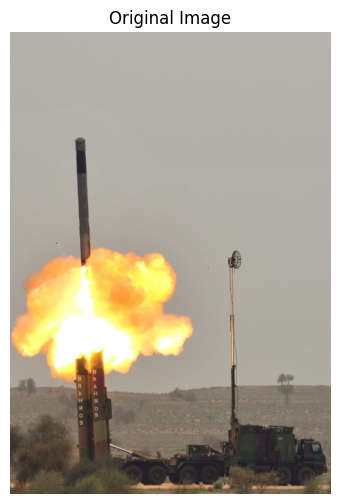

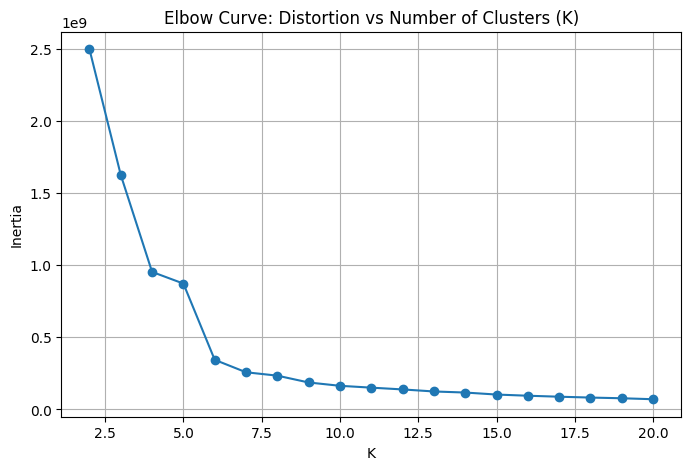

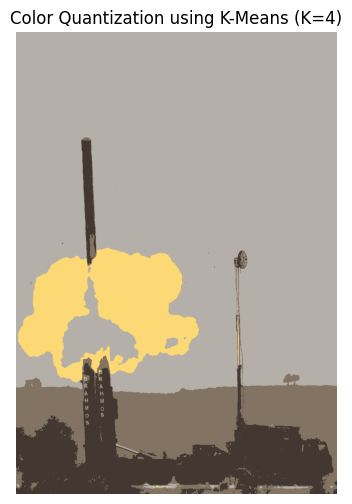

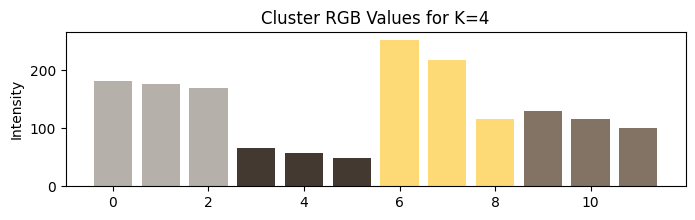

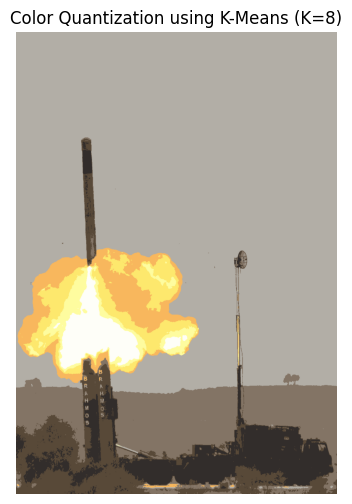

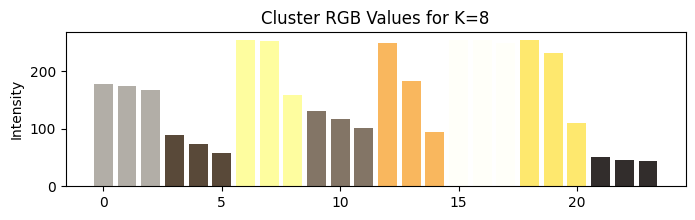

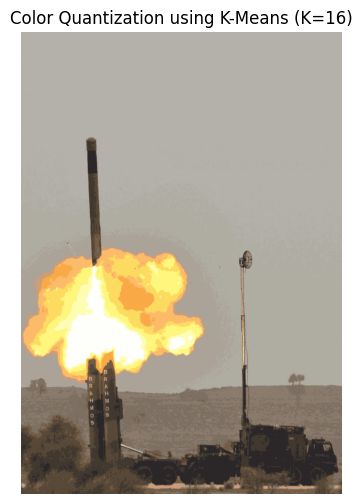

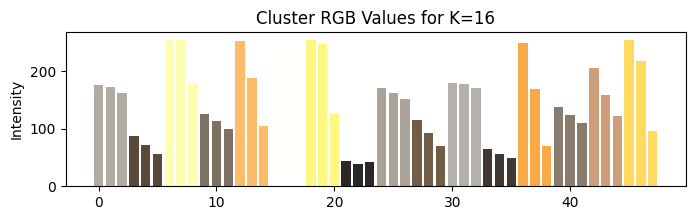

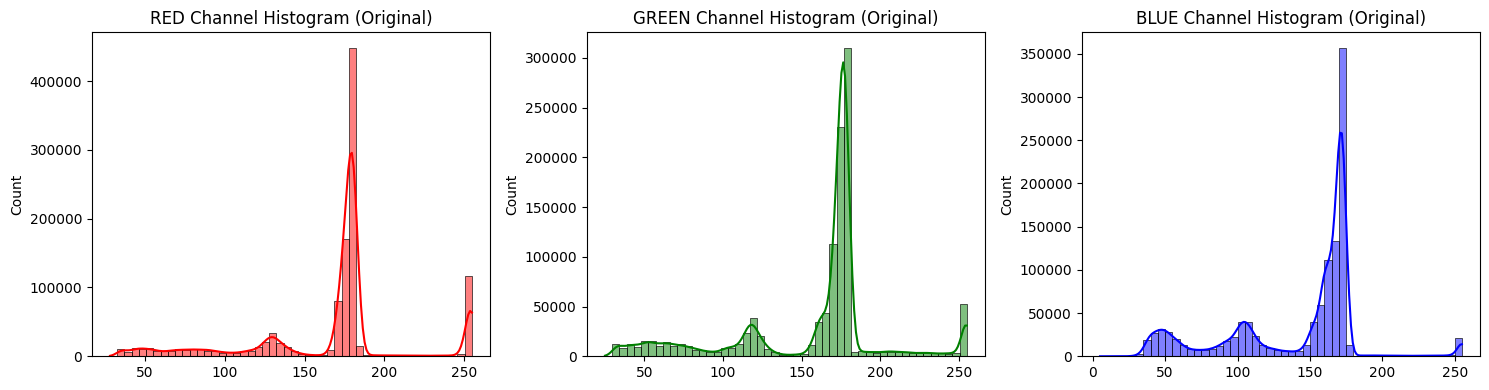

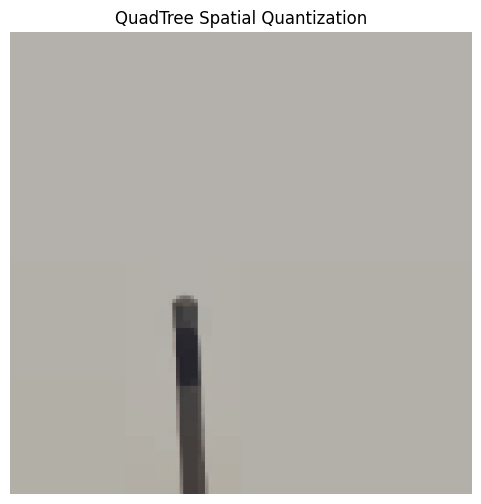

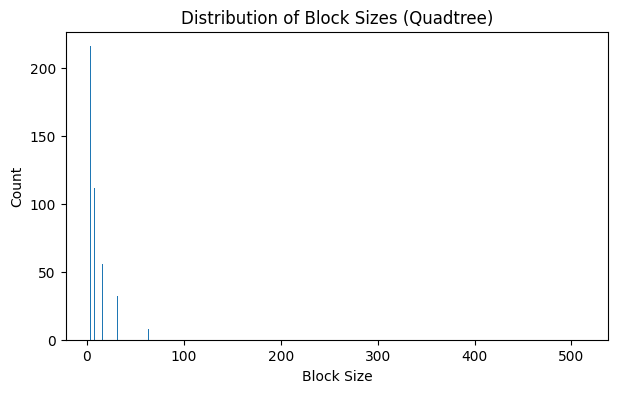

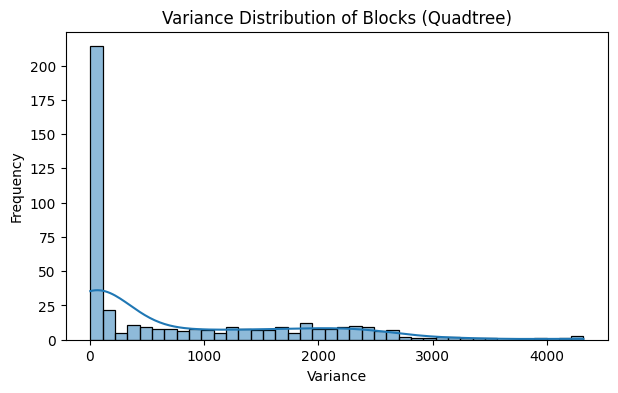

All graphs and outputs generated successfully!


In [1]:
# ============================================================
# FULL NON-UNIFORM QUANTIZATION NOTEBOOK WITH ALL GRAPHS
# ============================================================

# ----------------- STEP 1: UPLOAD IMAGE ---------------------
from google.colab import files
uploaded = files.upload()

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

img_path = list(uploaded.keys())[0]
img = cv2.imread(img_path)

if img is None:
    raise ValueError("Image failed to load.")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.show()


# ============================================================
# PART 1 — COLOR QUANTIZATION GRAPHS
# ============================================================

def kmeans_color_quantization(image, K):
    h, w = image.shape[:2]
    data = image.reshape((-1, 3))

    km = KMeans(n_clusters=K, random_state=42)
    labels = km.fit_predict(data)

    return km, labels, km.cluster_centers_

# ----------------- Elbow Curve ----------------------
Ks = list(range(2, 21))
inertias = []

for K in Ks:
    km = KMeans(n_clusters=K, random_state=42)
    km.fit(img.reshape(-1, 3))
    inertias.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(Ks, inertias, marker="o")
plt.title("Elbow Curve: Distortion vs Number of Clusters (K)")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


# ----------------- K-Means Quantization Outputs ----------------------
chosen_K = [4, 8, 16]

for K in chosen_K:
    km, labels, centers = kmeans_color_quantization(img, K)
    quant = centers.astype("uint8")[labels].reshape(img.shape)

    plt.figure(figsize=(6,6))
    plt.imshow(quant)
    plt.title(f"Color Quantization using K-Means (K={K})")
    plt.axis("off")
    plt.show()

    # Cluster center RGB bars
    plt.figure(figsize=(8,2))
    for i, c in enumerate(centers):
        plt.bar([i*3+0, i*3+1, i*3+2], c, color=c/255)
    plt.title(f"Cluster RGB Values for K={K}")
    plt.ylabel("Intensity")
    plt.show()


# ---------------- Pixel histograms ----------------------
plt.figure(figsize=(15,4))
colors = ['red','green','blue']
for i, col in enumerate(colors):
    plt.subplot(1,3,i+1)
    sns.histplot(img[:,:,i].flatten(), bins=50, kde=True, color=col)
    plt.title(f"{col.upper()} Channel Histogram (Original)")
plt.tight_layout()
plt.show()


# ============================================================
# PART 2 — NON-UNIFORM SPATIAL QUANTIZATION (QUADTREE)
# WITH BLOCK SIZE & VARIANCE GRAPHS
# ============================================================

block_sizes = []
block_vars = []

def variance(block):
    return np.var(block)

def quadtree(image, x, y, size, threshold, output):
    block = image[y:y+size, x:x+size]
    block_var = variance(block)

    block_vars.append(block_var)
    block_sizes.append(size)

    if size <= 4 or block_var < threshold:
        avg = np.mean(block.reshape(-1, 3), axis=0)
        output[y:y+size, x:x+size] = avg
        return

    half = size // 2
    quadtree(image, x, y, half, threshold, output)
    quadtree(image, x+half, y, half, threshold, output)
    quadtree(image, x, y+half, half, threshold, output)
    quadtree(image, x+half, y+half, half, threshold, output)

# resize to power of 2
H, W = img.shape[:2]
N = 2**int(np.floor(np.log2(min(H, W))))
img_resized = img[:N, :N]

threshold = 150
output = np.zeros_like(img_resized, dtype=float)

quadtree(img_resized, 0, 0, N, threshold, output)
qt_img = output.astype(np.uint8)

plt.figure(figsize=(6,6))
plt.imshow(qt_img)
plt.title("QuadTree Spatial Quantization")
plt.axis("off")
plt.show()


# ---------------- Graph 1: Block Size Distribution ----------------
plt.figure(figsize=(7,4))
unique_sizes, counts = np.unique(block_sizes, return_counts=True)
plt.bar(unique_sizes, counts)
plt.title("Distribution of Block Sizes (Quadtree)")
plt.xlabel("Block Size")
plt.ylabel("Count")
plt.show()

# ---------------- Graph 2: Block Variance Distribution -------------
plt.figure(figsize=(7,4))
sns.histplot(block_vars, bins=40, kde=True)
plt.title("Variance Distribution of Blocks (Quadtree)")
plt.xlabel("Variance")
plt.ylabel("Frequency")
plt.show()

print("All graphs and outputs generated successfully!")